In [2]:
# conversione in scala di grigi,filtraggio,calcolo dei gradienti, manipolazione img pixel
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import math

# Fase Preliminare:
### Caricamento immagine di test e conversione in scala di grigi


`cv2.imread('Test.png')` legge il file *Test.png* e lo memorizza nella variabile `Img` come matrice NumPy contenente i valori dei pixel nei tre canali di colore (R,G,B).

`cv2.cvtColor(Img, cv2.COLOR_BGR2GRAY)` converte l’immagine a toni di grigio, riducendo i tre canali di colore a un solo canale di intensità, necessario per l’elaborazione dei bordi.


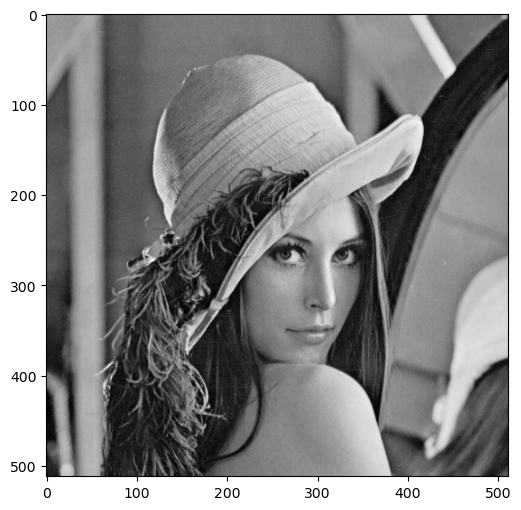

In [3]:
Img = cv2.imread('Test.png')
gray = cv2.cvtColor(Img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (6,6))
plt.imshow(gray, cmap='gray')
plt.show()


# **Prima Fase**:  
### Calcolo dimensione Maschere, Generazione delle Maschere, Creazione func. Gaussiana,Smoothing, Calcolo prime derivate func. Gaussiana

In questa fase dell’algoritmo di Canny si costruiscono le **maschere in x e y**, che servono a calcolare il gradiente dell’immagine. 

Queste maschere rappresentano le **prime derivate di una funzione Gaussiana** rispettivamente nelle direzioni x e y, e vengono generate a partire da un valore di **σ (sigma)**, che controlla la quantità di sfocatura applicata all’immagine prima di calcolare i bordi.


### **Funzioni**: 
### Calcolo dimensioni Maschere
Per costruire correttamente le maschere, bisogna determinare una **dimensione appropriata** (mask size).

* Se la maschera è troppo grande, l’operazione di convoluzione diventa più lenta senza portare reali vantaggi.
* Se invece è troppo piccola, non rappresenta bene la forma del filtro Gaussiano e si rischia di perdere informazioni sui bordi.

Per scegliere la dimensione giusta, si osserva il comportamento della funzione Gaussiana: 
si calcola il punto in cui il valore della Gaussiana scende sotto una soglia **T** compresa tra 0 e 1.

Matematicamente, si risolve l’equazione:
$$
e^{-\frac{x^2}{2\sigma^2}} = T
$$

Da questa, si ricava:
$$
s_{Half} = \text{round}\left(\sqrt{-\log(T) \cdot 2\sigma^2}\right)
$$
La dimensione totale della maschera sarà quindi:
$$
\text{masksize} = 2 \times s_{Half} + 1
$$
in modo da coprire sia il lato positivo che quello negativo del filtro.

Si impone inoltre che **σ ≥ 0.5**, perché valori più piccoli genererebbero maschere di dimensione minore di 3×3, troppo piccole per essere utili.

Nel sistema di riferimento usato:

* l’asse **x** è considerato **verso il basso (verticale)**,
* l’asse **y** è **verso destra (orizzontale)**.

Di conseguenza, le le aree positive e negative della maschera in direzione x sono disposte verticalmente, mentre quelle della maschera in direzione y sono disposte orizzontalmente.



In [4]:
def Half_mask(T, sigma):
    var = -np.log(T) * 2 * (sigma ** 2)
    return np.round(np.sqrt(var))

In [5]:
def Filter_size(T, sigma):
    return 2*Half_mask(T, sigma) + 1

### **Funzione**: 
### Generazione Maschere

* **`N = Filter_size(T, sigma)`**
  Calcola la **dimensione totale della maschera** (kernel) utilizzando la funzione `Filter_size`, che implementa la formula:
 $$
\text{N} = 2 \times s_{Half} + 1
$$
  dove `sHalf` è il valore calcolato da `Half_mask`.


Quindi, `N` rappresenta il numero di pixel (per lato) della finestra quadrata del filtro Gaussiano derivativo.


* **`half = Half_mask(T, sigma)`**
  Richiama la funzione già vista in precedenza per calcolare la **semidimensione della maschera**, ovvero quanti pixel si estendono dal centro verso ciascun lato.


Serve per definire l’intervallo dei valori di coordinate da utilizzare nella costruzione del kernel.

* **`y, x = np.meshgrid(range(-int(half), int(half) + 1), range(-int(half), int(half) + 1))`**


Costruisce due **matrici di coordinate** (`x` e `y`) della stessa dimensione `N × N`.

  * `range(-half, half + 1)` genera i valori interi simmetrici attorno a zero, es. per `half=2` → `[-2, -1, 0, 1, 2]`.
  * `np.meshgrid` produce due array 2D:

    * `x`: contiene per ogni punto la coordinata orizzontale (colonna),
    * `y`: contiene la coordinata verticale (riga).

Questi array rappresentano le **coordinate discrete** utilizzate per calcolare i valori delle maschere derivate ( **Gx(x, y)** ) e ( **Gy(x, y)** ) nei punti corrispondenti.

* **`return x, y`**
  Restituisce le due matrici di coordinate.

Saranno usate nei passaggi successivi per costruire i valori numerici effettivi dei filtri derivativi di Gaussiana (cioè le maschere ( **Gx(x, y)** ) e ( **Gy(x, y)** )).


In [6]:
def MaskGen(T, sigma):
    N = Filter_size(T, sigma)
    half = Half_mask(T, sigma)
    y, x = np.meshgrid(range(-int(half), int(half) + 1), range(-int(half), int(half) + 1))
    return x, y

### **Funzione**: 
### Calcolo Gaussiana


Calcola l’**esponente** della funzione Gaussiana bidimensionale, cioè il termine:
 $$
\frac{x^2 + y^2}{2\sigma^2}
$$

Questo rappresenta la distanza quadratica di ogni punto ((x, y)) dal centro, normalizzata rispetto alla varianza ( \sigma^2 ).

In termini geometrici, `var` descrive una **superficie radiale**: tutti i punti equidistanti dal centro hanno lo stesso valore di `var`, e quindi lo stesso contributo nella Gaussiana.

* **`return (np.exp(-var))`**
  
Applica l’esponenziale negativo, calcolando così la **Gaussiana normalizzata**:

  $$
e^{-\frac{x^2 + y^2}{2\sigma^2}}
$$

  Il risultato è una matrice 2D con valori compresi tra 0 e 1, massimi al centro (dove (x = y = 0)) e decrescenti esponenzialmente verso i bordi.
 
#### Significato geometrico

La Gaussiana 2D definisce una **superficie a campana** centrata nel punto (0,0):

* Il valore massimo si trova al centro e vale 1.
* I valori decrescono simmetricamente in tutte le direzioni con andamento esponenziale.
* L’ampiezza della campana è controllata da `σ`:

  * piccoli valori di `σ` producono un picco stretto (poca sfocatura),
  * grandi valori di `σ` producono una campana più larga (maggiore sfocatura).

#### Ruolo nell’algoritmo di Canny

Nel processo di rilevamento dei bordi, la Gaussiana serve a **ridurre il rumore** dell’immagine prima di calcolare le derivate.


In [7]:
def fGaussian(x,y, sigma):
    var = ((x ** 2) + (y ** 2)) / (2 * (sigma ** 2))
    return (np.exp(-var))

### **Funzioni**: 
### Calcolo Gradiente in X e Y

Calcoliamo i valori della **derivata prima della Gaussiana** rispetto all’asse (x), su coordinate `x`, `y` e per un valore dato di `sigma`.

* **`var = (x ** 2 + y ** 2) / (2 * sigma ** 2)`**

  Calcola il termine esponenziale comune a entrambe le derivate:

  $$
    \frac{x^2 + y^2}{2\sigma^2}
  $$

 Questo rappresenta la distanza radiale (quadrata) normalizzata di ciascun punto dal centro del filtro.

* **`return -((x * np.exp(-var)) / sigma ** 2)`**

  Calcola la **derivata della Gaussiana rispetto a (x)**, secondo la formula:

  $$
    G_x(x, y; \sigma) = -\frac{x}{\sigma^2} \, e^{-\frac{x^2 + y^2}{2\sigma^2}}
  $$
  In questo passaggio:

  * `np.exp(-var)` calcola il termine esponenziale;
  * `x / sigma**2` rappresenta il fattore di derivazione rispetto alla direzione x;
  * il segno meno deriva dalla derivazione analitica della funzione Gaussiana.

In [8]:
def gradientX(x,y, sigma):
    var = (x ** 2 + y ** 2) / (2 * sigma ** 2)
    return -((x * np.exp(-var)) / sigma ** 2)

Calcola la **derivata della Gaussiana rispetto a (y)**, secondo la formula:

  $$
    G_y(x, y; \sigma) = -\frac{y}{\sigma^2} \, e^{-\frac{x^2 + y^2}{2\sigma^2}}
  $$
  In questo passaggio:

  * `np.exp(-var)` calcola il termine esponenziale;
  * `y / sigma**2` rappresenta il fattore di derivazione rispetto alla direzione y;
  * il segno meno deriva dalla derivazione analitica della funzione Gaussiana.

In [9]:
def gradientY(x,y, sigma):
    var = (x ** 2 + y ** 2) / (2 * sigma ** 2)
    return -((y * np.exp(-var)) / sigma ** 2)

`gradientX` e `gradientY` sono i principali elementi per costruire le **maschere di convoluzione** che permettono di stimare i gradienti di intensità di un’immagine con smoothing, cioè senza amplificare il rumore.


Nel codice per il calcolo delle derivate della Gaussiana 2D, viene omessa la costante:

$$
\frac{1}{2\pi\sigma^2}
$$

perché la sua presenza non modifica la direzione del gradiente.


#### Significato geometrico

* La derivata in **x**, ( Gx ), misura **come cambia l’intensità luminosa lungo la direzione orizzontale** dell’immagine.

* La derivata in **y**, ( Gy ), misura **le variazioni lungo la direzione verticale**.

Grazie alla simmetria della Gaussiana, queste derivate hanno una forma a “lobo positivo e negativo”, con somma totale nulla, una caratteristica cruciale per rilevare variazioni di intensità (bordi) ma ignorare regioni uniformi.

#### Utilizzo nell'algoritmo, Canny Edge Detector

* Vengono applicate come **maschere di convoluzione** sull’immagine in scala di grigi.
* Producono le **componenti del gradiente** ( fx ) e ( fy ), ovvero le variazioni locali di intensità smussate dalla Gaussiana.
* Permettono di calcolare:
  $$
\text{Magnitudine: } \; M = \sqrt{f_x^2 + f_y^2}
\quad\text{e}\quad
\text{Direzione: } \; \theta = \tan^{-1}\left(\frac{f_y}{f_x}\right)
$$

che saranno utilizzate nelle fasi successive.




### **Funzioni**: 
### Calcolo e Scaling maschere derivate
Le funzioni `Gx` e `Gy` servono a **calcolare e scalare le derivate della Gaussiana** nelle direzioni *x* e *y*.

Questi valori costituiscono le **maschere derivate** necessarie alla *Fase 1* dell’algoritmo di Canny, ovvero quando si devono costruire i filtri ( Gx ) e ( Gy ) che verranno poi convoluti con l’immagine.

 **`gx = (gx * 255)`**
 **`gy = (gy * 255)`**
 
Scala i valori della derivata moltiplicandoli per 255, rendendo i valori interi e più gestibili (convoluzione più efficiente).

Le funzioni:
$$
gradientX(x, y; \sigma) = -\frac{x}{\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}
$$

$$
gradientY(x, y; \sigma) = -\frac{y}{\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}
$$

producono numeri nell’ordine di **0.0001 → 0.01**, molto piccolo.

Quando applichiamo la convoluzione tra immagine e maschera:

$$
fx = I * gradientX
$$

$$
fy = I * gradientY
$$

se i valori della maschera sono minuscoli, il risultato della convoluzione non sarà ottimo.

Per questo motivo scaliamo i valori con **255** che è il massimo valore della profondità a 8 bit:
$$
Gx = 255 \cdot gradientX
$$

$$
Gy = 255 \cdot gradientY
$$

Infine, portiamo la maschera in un intervallo molto più gestibile utilizzando:

**`return np.around(gx)`**

che arrotonda alla cifra intera più vicina, ottenendo una maschera con valori interi.



In [10]:
def Gx(fx, fy,sigma):
    gx = gradientX(fx, fy, sigma)
    gx = (gx * 255)
    return np.around(gx)

def Gy(fx, fy,sigma):    
    gy = gradientY(fx, fy, sigma)
    gy = (gy * 255)
    return np.around(gy)

## Applichiamo le funzioni appena definite implementando la prima fase dell'algoritmo

A partire dai valori di **sigma** e dalla soglia **T**, si determina automaticamente la dimensione della maschera, assicurandosi che sia sufficientemente ampia da rappresentare correttamente la distribuzione gaussiana ma non così grande da introdurre costi di calcolo inutili. 

Una volta stabilita la griglia di coordinate, la Gaussiana viene valutata punto per punto per ottenere il filtro di smoothing, che rappresenta il nucleo attorno al quale vengono poi costruite le derivate nelle direzioni orizzontale e verticale.

Il valore di **sigma** controlla quanto la Gaussiana è “larga” e, di conseguenza, quanto forte sarà la fase di smoothing. Con un sigma piccolo la maschera diventa più concentrata e il filtraggio rimuove poco rumore, mentre con un sigma più grande il filtro agisce in modo più deciso, rendendo l’immagine più uniforme ma rischiando anche di attenuare dettagli importanti.

**Sigma determina la scala alla quale l’algoritmo osserva i bordi**.

La soglia **T**, invece, viene utilizzata per stabilire fin dove la Gaussiana mantiene valori significativi e quindi per determinare automaticamente la dimensione della maschera. Quando il valore della Gaussiana scende sotto questa soglia, il suo contributo al filtro diventa trascurabile: da qui si ricava l’estensione spaziale del kernel. 

In questo modo si evita di costruire maschere troppo piccole (che troncano la Gaussiana) o inutilmente grandi (che aumentano il costo computazionale senza benefici).

In [11]:
sigma = 0.5
T = 0.3
x, y = MaskGen(T, sigma)
gauss = fGaussian(x, y, sigma)

In [12]:
print(f"X:\n{x}\n")
print(f"Y:\n{y}\n")
print(f"Gaussiana:\n{gauss}\n")

X:
[[-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]]

Y:
[[-1  0  1]
 [-1  0  1]
 [-1  0  1]]

Gaussiana:
[[0.01831564 0.13533528 0.01831564]
 [0.13533528 1.         0.13533528]
 [0.01831564 0.13533528 0.01831564]]



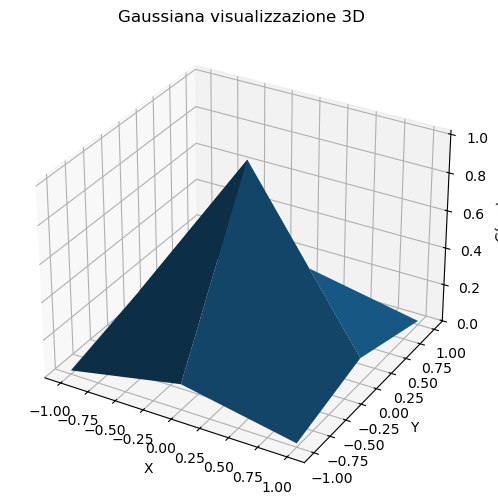

In [13]:
# Plot 3D Gaussiana
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, gauss, rstride=1, cstride=1)

ax.set_title("Gaussiana visualizzazione 3D")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("G(x,y)")

plt.show()

## Smoothing dell'immagine utilizzando la Gaussiana

### Funzione `pad(Img, kernel)`:

Questa funzione serve ad **espandere i bordi dell’immagine** con zeri, così da poter applicare correttamente la convoluzione anche sui pixel del bordo.

Senza padding non possiamo calcolare i valori ai bordi, perché mancherebbero pixel esterni.

```
padd = np.zeros((righe + krighe, colonne + kcolonne), dtype=Img.dtype)
```
Creaiamo una nuova immagine più grande, riempita di zeri,la dimensione extra dipende dalla dimensione del kernel.

```
padd[insert: insert + righe, insert: insert + colonne] = Img
```
Inseriamo l’immagine originale **al centro** della matrice padded.


In [14]:
def pad(Img, kernel):
    righe, colonne = Img.shape
    krighe, kcolonne = kernel.shape
    padd = np.zeros((righe + krighe,colonne + kcolonne), dtype=Img.dtype)
    insert =int((krighe)/2)
    padd[insert: insert + righe, insert: insert + colonne] = Img
    return padd

### Funzione `smooth(Img, kernel=None)`

Questa funzione esegue una **convoluzione** tra l’immagine e un kernel.
Serve per applicare **filtraggio spaziale**:

* smoothing 
* blur
* riduzione del rumore

```
if kernel is None:
    maschera = np.array([[1,1,1],[1,1,1],[1,1,1]])
else:
    maschera = kernel
```
Se non viene fornito un kernel, usa di default un filtro di **media 3×3**.

Ciclo di convoluzione

```
for x in range(Img.shape[0]):    
    for y in range(Img.shape[1]):
```
Scorre tutti i pixel dell’immagine.

```
var[x, y] = (maschera * image_padded[x:x+i, y:y+j]).sum() / maschera.sum()
```

Qui avviene la vera **convoluzione**:

1. Si prende un blocco di immagine delle dimensioni del kernel
2. Si moltiplica elemento per elemento con il kernel
3. Si sommano i risultati
4. Si divide per la somma del kernel (smoothing)

In [15]:
def smooth(Img, kernel=None):
    if kernel is None:
        maschera = np.array([[1,1,1],[1,1,1],[1,1,1]])
    else:
        maschera = kernel
    i, j = maschera.shape
    var = np.zeros((Img.shape[0], Img.shape[1]))           
    image_padded = pad(Img, maschera)
    for x in range(Img.shape[0]):    
        for y in range(Img.shape[1]):
            var[x, y] = (maschera * image_padded[x:x+i, y:y+j]).sum() / maschera.sum()  
    return var

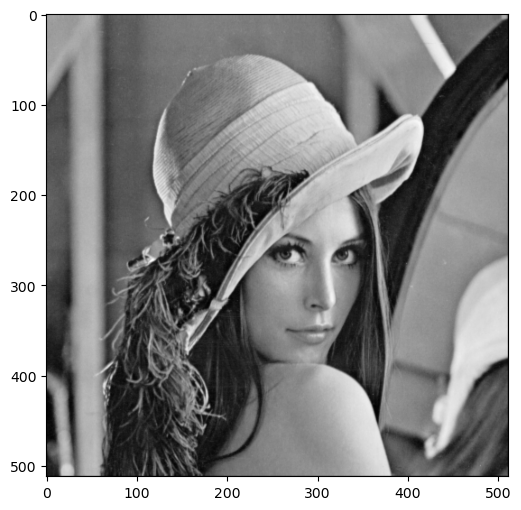

In [16]:
smooth_img = smooth(gray, gauss)
plt.figure(figsize = (6,6))
plt.imshow(smooth_img, cmap='gray')

## Creazione Componenti del Gradiente
Mettiamo il segno meno perché:
* invertendo il segno otteniamo una rappresentazione più coerente con filtri standard (es. Sobel),
* questo facilita visualizzazione, confronto e interpretazione,
* **l’algoritmo Canny non cambia**, perché magnitudine e orientazione restano equivalenti.

In [17]:
gx = -Gx(x, y,sigma)
gy = -Gy(x, y,sigma)

In [18]:
print(f"Gx:\n{gx}\n")
print(f"Gy:\n{gy}\n")

Gx:
[[ -19. -138.  -19.]
 [   0.    0.    0.]
 [  19.  138.   19.]]

Gy:
[[ -19.    0.   19.]
 [-138.    0.  138.]
 [ -19.    0.   19.]]



# **Seconda Fase:**
### Applichiamo le maschere dei Gradienti

Una volta generate le maschere dei gradienti ( Gx ) e ( Gy ), il passo successivo nell’algoritmo di Canny consiste nell’applicarle all’immagine per ottenere le due componenti principali del gradiente: quella lungo l’asse x e quella lungo l’asse y.

Ricordiamo la definizione di **convoluzione**: un’operazione fondamentale nell’elaborazione delle immagini che permette di combinare l’informazione locale dei pixel con una maschera (kernel) che rappresenta l’operatore desiderato in questo caso l’operatore derivativo.

La funzione `ApplyGradientMask` implementa la convoluzione tra l’immagine e una delle due maschere di gradiente in base all'input.

Questa funzione calcola come varia l’intensità dei pixel lungo una direzione specifica: la maschera `gx` rileva variazioni orizzontali (quindi bordi verticali), mentre la maschera `gy` rileva variazioni verticali (bordi orizzontali). 

Il risultato sono due immagini, `fx` e `fy`, che rappresentano la risposta del filtro alle diverse direzioni.

In [19]:
def ApplyGradientMask(Img, kernel):
    i, j = kernel.shape
    kernel = np.flipud(np.fliplr(kernel))    
    var = np.zeros_like(Img)           
    image_padded = pad(Img, kernel)
    for x in range(Img.shape[0]):    
        for y in range(Img.shape[1]):
            var[x, y] = (kernel * image_padded[x:x+i, y:y+j]).sum()        
    return var

## Rotazione del Kernel

``
kernel = np.flipud(np.fliplr(kernel))
``

Nel calcolo della convoluzione, il kernel deve essere ruotato di 180°.

Questo deriva dalla definizione matematica stessa della convoluzione, che richiede di invertire le coordinate del kernel.

L’operazione viene implementata tramite un doppio flip—orizzontale e verticale—ottenuto con `np.fliplr()` e `np.flipud()`. 

Senza questa rotazione, non si eseguirebbe una convoluzione ma una correlazione, che porta a gradienti orientati in modo errato.

La convoluzione tra un'immagine (I) e un kernel (K) è definita come:

$$
(I * K)(x, y) = \sum_{i}\sum_{j} I(x-i, y-j); K(i, j)
$$

Quindi:

* l'immagine usa coordinate **invertite**: ( (x-i, y-j) )
* questo è equivalente a ruotare il kernel di 180°

Infatti, la forma alternativa della stessa equazione, quella che utilizziamo noi nel codice:

$$
(I * K)(x, y) = \sum_{i}\sum_{j} I(x+i, y+j); K(-i, -j)
$$

e (K(-i, -j)) indica il **kernel ruotato di 180°**.





``
var[x, y] = (kernel * image_padded[x:x+i, y:y+j]).sum()
``

**Convoluzione**:

1. Si estrae una finestra dell’immagine della stessa dimensione del kernel
2. Si moltiplicano elemento per elemento finestra e kernel
3. Si sommano i valori ottenuti
4. Il risultato è il valore del gradiente in quel punto

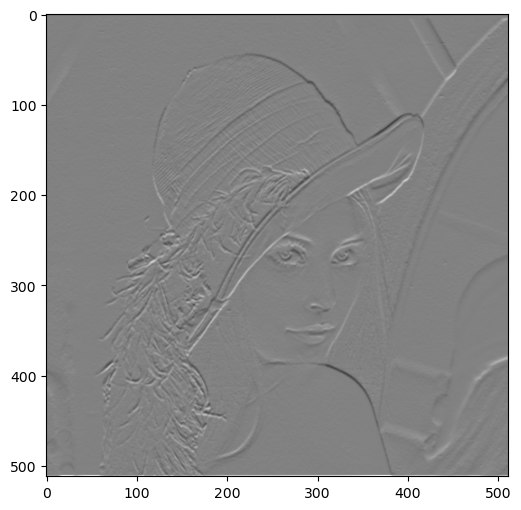

In [20]:
fx = ApplyGradientMask(smooth_img, gx)
plt.figure(figsize = (6,6))
plt.imshow(fx, cmap='gray')

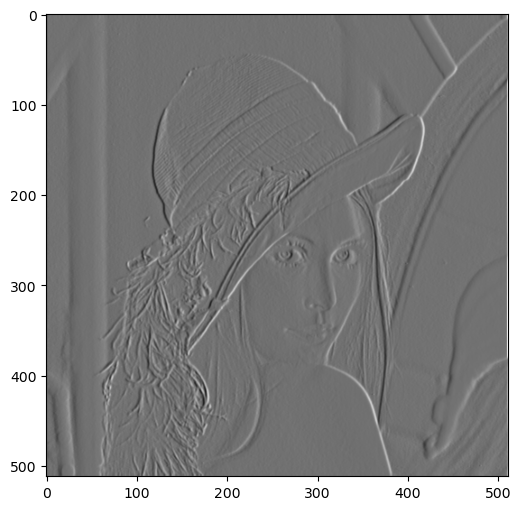

In [21]:
fy = ApplyGradientMask(smooth_img, gy)
plt.figure(figsize = (6,6))
plt.imshow(fy, cmap='gray')

# **Terza Fase:**
### Calcoliamo la magnitude del Gradiente

In [22]:
def Gradient_Magnitude(fx, fy):
    mg = np.zeros((fx.shape[0], fx.shape[1]))
    mg = np.sqrt((fx ** 2) + (fy ** 2))
    mg = mg * 100 / mg.max()
    return np.around(mg)

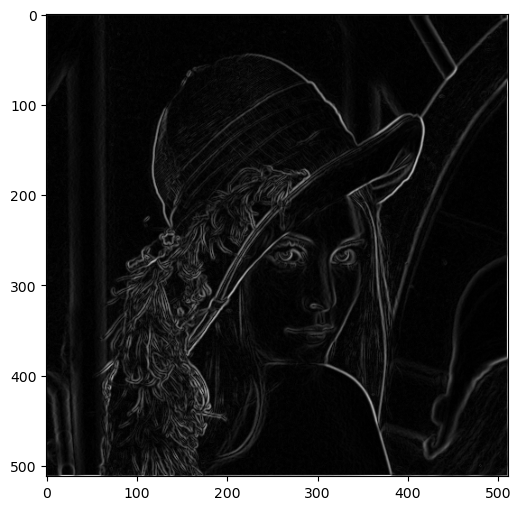

In [24]:
mg = Gradient_Magnitude(fx, fy)
mg = mg.astype(int)
plt.figure(figsize = (6,6))
plt.imshow(mg, cmap='gray')